<a href="https://colab.research.google.com/github/rrsguim/PhD_Economics/blob/master/TL4OG/OutputGap_LSTM_US_BR_lock.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

------------------------------------------------------------------------------------------------------
Copyright (c) 2020 Rafael Guimaraes

This work was done when I was at the University of California, Riverside, USA. 

It is part of my doctoral thesis in Economics at the Federal University of 

Rio Grande do Sul, Porto Alegre, Brazil.


See full material at https://github.com/rrsguim/PhD_Economics

The code below, under the Apache License, was inspired by

*Classification on imbalanced data*, and 

*Introduction to the Keras Tuner*

Copyright 2020 The TensorFlow Authors

https://www.tensorflow.org/tutorials/structured_data/imbalanced_data

https://www.tensorflow.org/tutorials/keras/keras_tuner

-------------------------------------------------------------------------

# Transfer Learning for Output Gap Estimation

##Setup

In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals

In [ ]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

In [ ]:
!pip install -U keras-tuner

Requirement already up-to-date: keras-tuner in /usr/local/lib/python3.6/dist-packages (1.0.2)


In [ ]:
import tensorflow as tf
from tensorflow import keras

import IPython

import kerastuner as kt
from kerastuner import RandomSearch

import os
import tempfile

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [ ]:
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

## Deep Learning | United States

###Data loading and pre-processing

#### Download the data set

##### The Dataset

We use FRED Economic Data, provided by the Federal Reserve Bank of Saint Louis. Each row in the CSV file corresponds to a quarter, and each column describes an attribute. We will use this information to estimate the output gap.

Following is a description of this dataset. Notice that there are both numeric and categorical columns. All data refer to United States of America from 1967Q1 to 2020Q3.

>Column| Source| Description| Feature Type | Data Type
>------------|--------------------|----------------------|-----------------|----------------
>Unemployment | FRED-MD | UNRATE - Unemployment rate, percent, s.a., quarterly average | Numerical | float
>Capacity | FRED-MD | TCU - Capacity utilization index, percent, s.a., quarterly average | Numerical | float
>Business cycle | FRED-MD | USRECQ - NBER based Recession Indicator (1 = true; 0 = false) | Classification | integer
>Potential GDP | FRED-MD | GDPPOT - Real potential gross domestic product, US billions dollars, quarterly | Numerical | float
>Real GDP | FRED-MD | GDPC1 - Real gross domestic product, s.a., US billions dollars, quarterly | Numerical | float
>Target |  | = ( RealGDP - PotentialGDP ) / RealGDP * 100, percent | Numerical | float

In [ ]:
file = tf.keras.utils
raw_data = pd.read_csv('https://raw.githubusercontent.com/rrsguim/PhD_Economics/master/TL4OG/TL4OG_US_data.csv')

In [ ]:
raw_data.index = raw_data['DATE']
drop_DATE = raw_data.pop('DATE')
raw_data.index = pd.to_datetime(raw_data.index,infer_datetime_format=True)
raw_data.index = raw_data.index.to_period("Q")

Observe last lines of the adjusted dataset.

In [ ]:
raw_data.tail()

,unrate,tcu,NBER,GAP
DATE,,,,
2019Q3,3.60,77.57,0,1.04
2019Q4,3.60,77.24,0,1.17
2020Q1,3.80,75.79,0,-0.55
2020Q2,13.07,65.97,1,-10.99
2020Q3,8.80,72.14,1,-3.68


#### Inspect pre-processed data

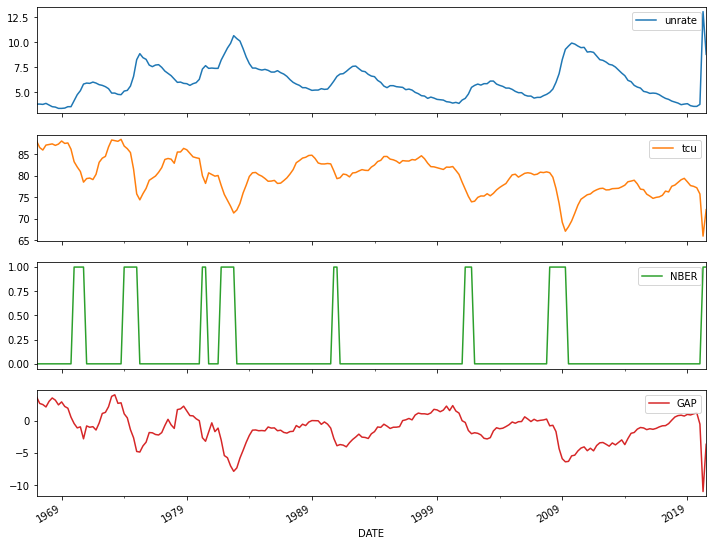

In [ ]:
plot_cols = ['unrate', 'tcu', 'NBER', 'GAP'] 
plot_features = raw_data[plot_cols]
plot_features.index = raw_data.index
_ = plot_features.plot(subplots=True)

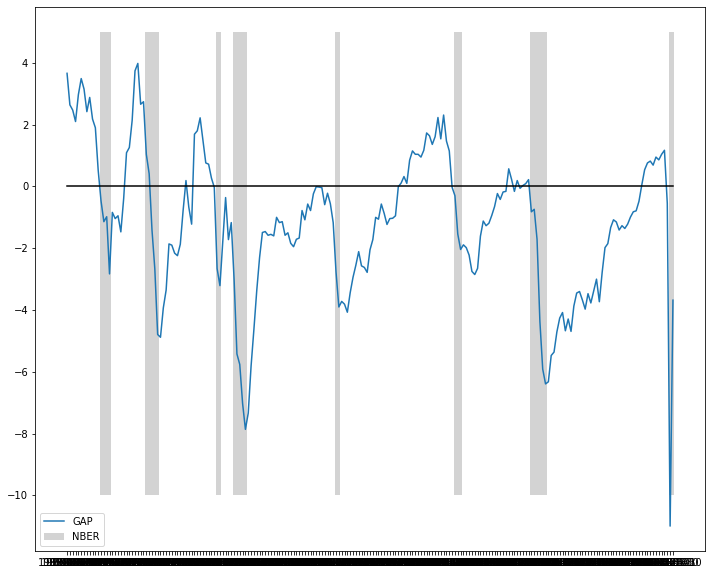

In [ ]:
plt.plot(drop_DATE, raw_data['GAP'], label='GAP')
plt.bar(drop_DATE, raw_data['NBER']*-10 , width=1, linewidth=1, align='center', color="lightgray", label='NBER') 
plt.bar(drop_DATE, raw_data['NBER']*5 , width=1, linewidth=1, align='center', color="lightgray") 
plt.plot(drop_DATE, np.zeros(drop_DATE.shape[0]), color='black')
plt.legend()
plt.show()

In [ ]:
raw_data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
unrate,215.0,6.091907,1.730741,3.40,4.850,5.73,7.230,13.07
tcu,215.0,80.094558,4.292762,65.97,77.105,80.28,83.330,88.53
NBER,215.0,0.134884,0.342397,0.00,0.000,0.00,0.000,1.00
GAP,215.0,-1.182651,2.345025,-10.99,-2.595,-1.06,0.225,3.98


#### Split, but no shuffle

Split the dataset into train, validation, and test sets. The validation set is used during the model fitting to evaluate the loss and any metrics, however, the model is not fit with this data. The test set is completely unused during the training phase and is only used at the end to evaluate how well the model generalizes to new data.

In [ ]:
# Use a utility from sklearn to split our dataset.
train_df, test_df = train_test_split(raw_data, test_size=0.2, random_state=0, shuffle=False)  #
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=0, shuffle=False) 
print(len(train_df), 'train examples')
print(len(val_df), 'validation examples')
print(len(test_df), 'test examples') 



137 train examples
35 validation examples
43 test examples


#### Normalize

It is important to scale features before training a neural network. Normalization is a common way of doing this scaling. Subtract the mean and divide by the standard deviation of each feature.

The mean and standard deviation should only be computed using the training data so that the models have no access to the values in the validation and test sets.


In [ ]:
#NBER is a dummy, so we don't normalize it. We also don't normalize the target (GAP)
NBER_train = train_df.pop('NBER')
GAP_train = train_df.pop('GAP')
NBER_val = val_df.pop('NBER')
GAP_val = val_df.pop('GAP')
NBER_test = test_df.pop('NBER')
GAP_test = test_df.pop('GAP')

train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

#put NBER and GAP back
train_df['NBER'] = NBER_train
train_df['GAP'] = GAP_train
val_df['NBER'] = NBER_val
val_df['GAP'] = GAP_val
test_df['NBER'] = NBER_test
test_df['GAP'] = GAP_test

#### Split features from labels

In [ ]:
# Form np arrays of labels and features.
train_labels = np.array(train_df.pop('GAP'))
val_labels = np.array(val_df.pop('GAP'))
test_labels = np.array(test_df.pop('GAP'))

train_features = np.array(train_df)
val_features = np.array(val_df)
test_features = np.array(test_df)

### DL model

Adjust model input dim because of LSTM

In [ ]:
train_features = np.expand_dims(train_features, 1)
val_features = np.expand_dims(val_features, 1)
test_features = np.expand_dims(test_features, 1)

#### Define the model and metrics

Define a function that creates a deep neural network with LSTM and densly connected hidden layers, regularizers to reduce overfitting, and an output layer that returns the output gap estimation. Also, pick the optimal set of hyperparameters with [Keras Tunner](https://www.tensorflow.org/tutorials/keras/keras_tuner).

In [ ]:
def make_model(hp):  

  model = keras.Sequential()
  # Tune the number of units in the layers
  # Choose an optimal value between 16-256
  hp_lstm_units = hp.Int('lstm_units', min_value = 16, max_value = 256, step = 16)
  hp_dense_units = hp.Int('dense_units', min_value = 16, max_value = 256, step = 16)


### LSTM ###
  # Tune the dropout
  # Choose an optimal value from 0.2 to 0.7
  hp_dropout = hp.Float('dropout', 0.2, 0.7, step=0.1, default=0.5)

  model.add(keras.layers.LSTM(units = hp_lstm_units, input_shape = (1,train_features.shape[-1],), dropout = hp_dropout))
### LSTM ###


### DENSE ###
  # Tune the lambda for the regularizer
  # Choose an optimal value from 0.01, 0.001, or 0.0001
  hp_reg_lambda = hp.Choice('reg_lambda', values = [1e-2, 1e-3, 1e-4])

  #Tune the activation function
  hp_activation=hp.Choice('dense_activation', values=['relu', 'tanh', 'sigmoid'], default='relu')

  #LASSO (L1)
  model.add(keras.layers.Dense(units = hp_dense_units, kernel_regularizer=keras.regularizers.l1(hp_reg_lambda), activation = hp_activation)) #Dense layer 1
  model.add(keras.layers.Dense(units = hp_dense_units, kernel_regularizer=keras.regularizers.l1(hp_reg_lambda), activation = hp_activation)) #Dense layer 2
  model.add(keras.layers.Dense(units = hp_dense_units, kernel_regularizer=keras.regularizers.l1(hp_reg_lambda), activation = hp_activation)) #Dense layer 3
  model.add(keras.layers.Dense(units = hp_dense_units, kernel_regularizer=keras.regularizers.l1(hp_reg_lambda), activation = hp_activation)) #Dense layer 4

  #Ridge (L2)
  #model.add(keras.layers.Dense(units = hp_dense_units, kernel_regularizer=keras.regularizers.l2(hp_reg_lambda), activation = hp_activation)) #Dense layer 1
  #model.add(keras.layers.Dense(units = hp_dense_units, kernel_regularizer=keras.regularizers.l2(hp_reg_lambda), activation = hp_activation)) #Dense layer 2
  #model.add(keras.layers.Dense(units = hp_dense_units, kernel_regularizer=keras.regularizers.l2(hp_reg_lambda), activation = hp_activation)) #Dense layer 3
  #model.add(keras.layers.Dense(units = hp_dense_units, kernel_regularizer=keras.regularizers.l2(hp_reg_lambda), activation = hp_activation)) #Dense layer 4 
### DENSE ###


  model.add(keras.layers.Dense(1)) # Output layer


  # Tune the learning rate for the optimizer 
  # Choose an optimal value from 0.01, 0.001, or 0.0001
  hp_learning_rate = hp.Choice('learning_rate', values = [1e-2, 1e-3, 1e-4])


  model.compile(optimizer = keras.optimizers.Adam(learning_rate = hp_learning_rate),
                #optimizer = keras.optimizers.Adagrad(learning_rate = hp_learning_rate),
                loss = keras.losses.MeanSquaredError(), 
                metrics = [keras.metrics.MeanAbsoluteError()])
   
  return model

#TL4OG_model = make_model()


In [ ]:
tuner = kt.Hyperband(make_model, 
                     kt.Objective('val_mean_absolute_error', direction='min'), #
                     max_epochs = 50,) #15
                     #factor = 3,)
                     #project_name = 'TL4OG')

#### Train the model

Before running the hyperparameter search, define a callback to clear the training outputs at the end of every training step.

In [ ]:
class ClearTrainingOutput(tf.keras.callbacks.Callback):
  def on_train_end(*args, **kwargs):
    IPython.display.clear_output(wait = True)

Run the hyperparameter search. The arguments for the search method are the same as those used for tf.keras.model.fit in addition to the callback above.

In [ ]:
tuner.search(train_features, train_labels,
             epochs=50,
             validation_data=(val_features, val_labels), callbacks = [ClearTrainingOutput()])

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the lstm layer is {best_hps.get('lstm_units')}, in the densely-connected
layers is {best_hps.get('dense_units')}, while the activation function is {best_hps.get('dense_activation')}, the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}, the optimal lambda for the regularizer is {best_hps.get('reg_lambda')}, and the optimal dropout for the LSTM is {best_hps.get('dropout')}.
""")

Trial 90 Complete [00h 00m 06s]
val_mean_absolute_error: 0.438708633184433

Best val_mean_absolute_error So Far: 0.3684784770011902
Total elapsed time: 00h 05m 23s
INFO:tensorflow:Oracle triggered exit

The hyperparameter search is complete. The optimal number of units in the lstm layer is 128, in the densely-connected
layers is 240, while the activation function is relu, the optimal learning rate for the optimizer
is 0.001, the optimal lambda for the regularizer is 0.01, and the optimal dropout for the LSTM is 0.30000000000000004.



Retrain the model with the optimal hyperparameters from the search.

In [ ]:
# Build the model with the optimal hyperparameters and train it on the data
model = tuner.hypermodel.build(best_hps)
baseline_history = model.fit(train_features, train_labels,
             epochs=200,
             validation_data=(val_features, val_labels))

Epoch 1/200
5/5 [==============================] - 2s 127ms/step - loss: 119.3224 - mean_absolute_error: 1.8930 - val_loss: 112.2243 - val_mean_absolute_error: 1.6550
Epoch 2/200
5/5 [==============================] - 0s 15ms/step - loss: 110.1428 - mean_absolute_error: 1.9447 - val_loss: 102.6428 - val_mean_absolute_error: 1.6133
Epoch 3/200
5/5 [==============================] - 0s 15ms/step - loss: 100.6968 - mean_absolute_error: 1.8627 - val_loss: 93.5256 - val_mean_absolute_error: 1.5726
Epoch 4/200
5/5 [==============================] - 0s 15ms/step - loss: 91.0509 - mean_absolute_error: 1.7670 - val_loss: 84.8507 - val_mean_absolute_error: 1.5326
Epoch 5/200
5/5 [==============================] - 0s 14ms/step - loss: 83.0938 - mean_absolute_error: 1.8292 - val_loss: 76.5676 - val_mean_absolute_error: 1.4881
Epoch 6/200
5/5 [==============================] - 0s 15ms/step - loss: 75.0215 - mean_absolute_error: 1.7793 - val_loss: 68.6786 - val_mean_absolute_error: 1.4346
Epoch 7/20

#### Results

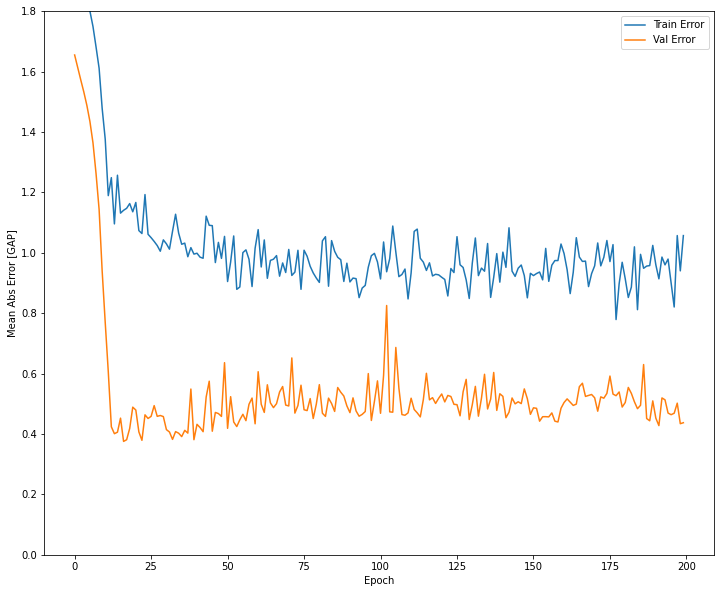

In [ ]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch
  

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [GAP]')
  plt.plot(hist['epoch'], hist['mean_absolute_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_absolute_error'],
           label = 'Val Error')
  plt.ylim([0,1.8])
  plt.legend()

  plt.show()


plot_history(baseline_history)

Training set

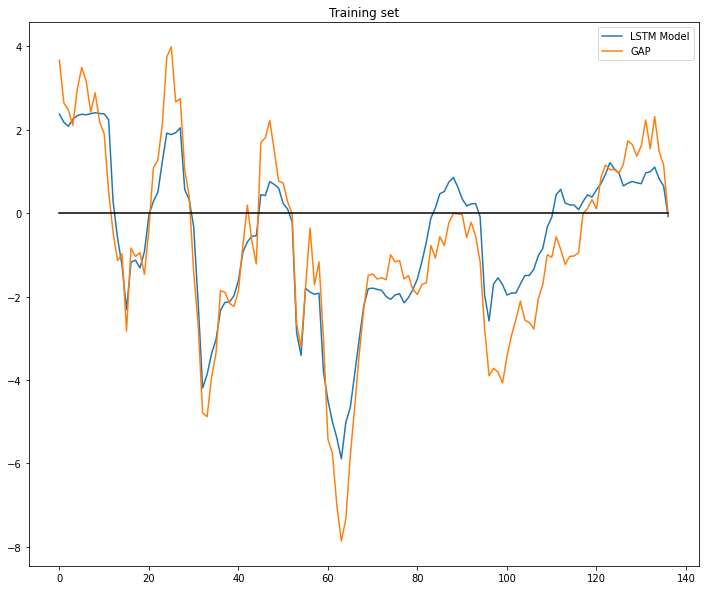

In [ ]:
time_axis_train = range(0,train_labels.shape[0])
plt.title('Training set')
plt.plot(time_axis_train, model.predict(train_features).flatten(), label='LSTM Model') ### Training set
plt.plot(time_axis_train, train_labels, label='GAP')
plt.plot(time_axis_train, np.zeros(train_labels.shape[0]), color='black')
plt.legend()
plt.show()

Test set

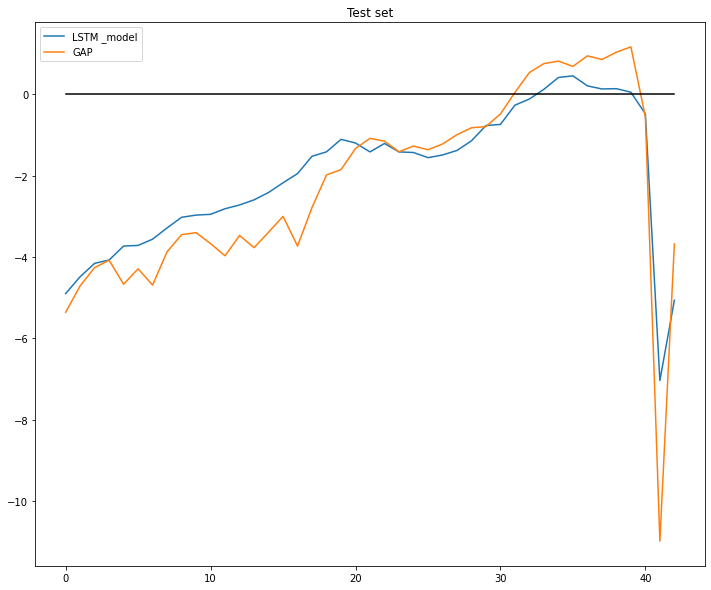

In [ ]:
time_axis_test = range(0,test_labels.shape[0]) #Test set
LSTM_model = model.predict(test_features) # Test set
plt.title('Test set')
#plt.bar(time_axis_test, test_labels.T, width=1, linewidth=1, align='center', color="lightgray", label='GAP') 
plt.plot(time_axis_test, LSTM_model, label='LSTM _model')
plt.plot(time_axis_test, test_labels, label='GAP')
plt.plot(time_axis_test, np.zeros(test_labels.shape[0]), color='black')
plt.legend()
plt.show()

In [ ]:
US_test_error = LSTM_model.flatten() - test_labels
MAE_test_set = np.sum(np.abs(US_test_error))/US_test_error.shape
MAE_test_set

array([0.65368592])

All data

In [ ]:
x = raw_data

#Normalize
#NBER is a dummy, so we don't normalize it. The GAP is not normalized too.
NBER_x = x.pop('NBER')
GAP_x = x.pop('GAP')

x_mean = x.mean()
x_std = x.std()
x = (x - x_mean) / x_std

#put NBER and GAP back
x['NBER'] = NBER_x
x['GAP'] = GAP_x

#split labels
y = x.pop('GAP')

In [ ]:
x = np.expand_dims(x, 1) # (because of LSTM)

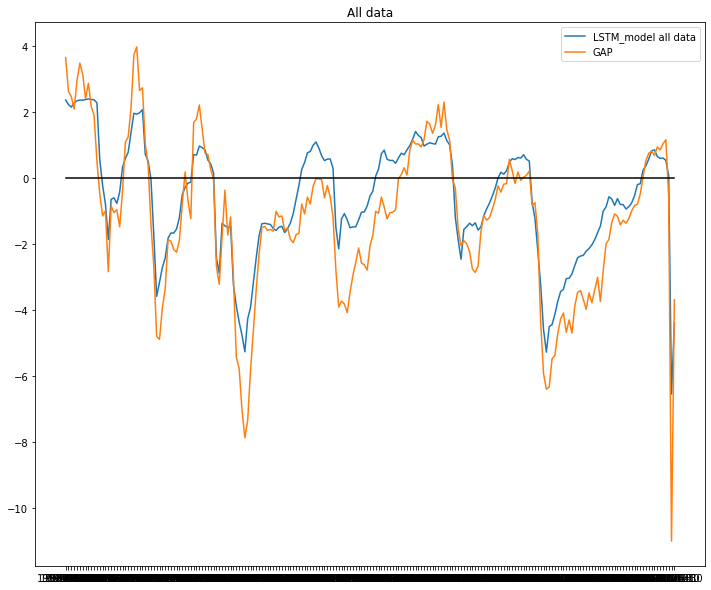

In [ ]:
LSTM_model_all_data = model.predict(x) # All data
plt.title('All data') 
plt.plot(drop_DATE, LSTM_model_all_data, label='LSTM_model all data')
plt.plot(drop_DATE, y, label='GAP')
plt.plot(drop_DATE, np.zeros(drop_DATE.shape[0]), color='black')
plt.legend()
plt.show()

## Transfer Learning | Brazil

### Brazil

#### Data

There are two data sets for Brazil because of methodology changes in unemployment rate. Set 1 from 2001-IV to 2015-IV and Set 2 from 2012-II to 2020-III.

>Column| Source| Description| Feature Type | Data Type
>------------|--------------------|----------------------|-----------------|----------------
>Unemployment | FRED-MD | UNRATE - Unemployment rate, percent, s.a., quarterly average | Numerical | float
>Capacity | FRED-MD | TCU - Capacity utilization index, percent, s.a., quarterly average | Numerical | float
>TFP | FRED-MD | Total Factor Productivity Level at Current Purchasing Power Parities for Brazil, Index USA = 1 | Numerical | float
>Business cycle | CODACE | CODACE based Recession Indicator (1 = true; 0 = false) | Classification | integer
>GAP |  | Output Gap, percent | Numerical | float

In [ ]:
#raw_data_BR = pd.read_csv('https://raw.githubusercontent.com/rrsguim/PhD_Economics/master/TL4OG/TL4OG_BR_data_to2015.csv') #to 2015 (because of Unrate methodology)
raw_data_BR = pd.read_csv('https://raw.githubusercontent.com/rrsguim/PhD_Economics/master/TL4OG/TL4OG_BR_data_since2012.csv') #since 2012 (because of Unrate methodology)

In [ ]:
raw_data_BR.index = raw_data_BR['DATE']
drop_DATE_BR = raw_data_BR.pop('DATE')
raw_data_BR.index = pd.to_datetime(raw_data_BR.index,infer_datetime_format=True)
raw_data_BR.index = raw_data_BR.index.to_period("Q")

Inspect data

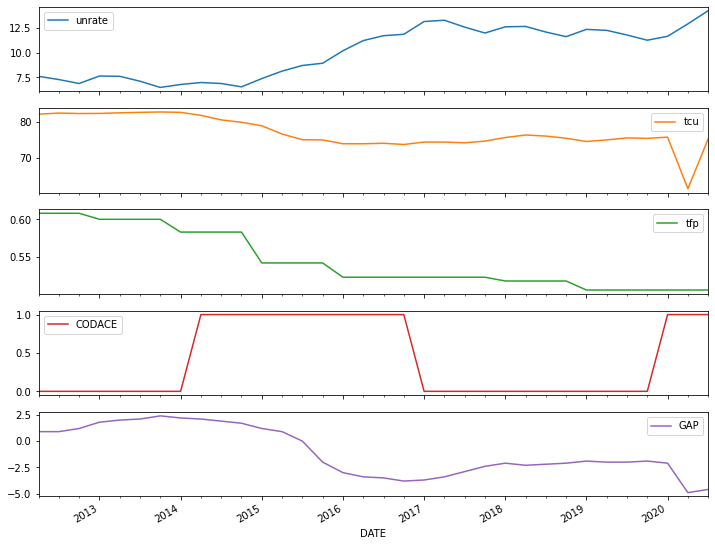

In [ ]:
plot_cols = ['unrate', 'tcu', 'tfp', 'CODACE', 'GAP'] 
plot_features = raw_data_BR[plot_cols]
plot_features.index = raw_data_BR.index
_ = plot_features.plot(subplots=True)

In [ ]:
tfp_BR = raw_data_BR.pop('tfp')

In [ ]:
#with TFP adjustment
raw_data_BR['unrate'] = raw_data_BR['unrate']*tfp_BR
raw_data_BR['tcu'] = raw_data_BR['tcu']*tfp_BR

In [ ]:
w = raw_data_BR

#Normalize
#CODACE is a dummy, so we don't normalize it. The target is not normalized too.
CODACE_w = w.pop('CODACE')
GAP_w = w.pop('GAP')

w_mean = w.mean()
w_std = w.std()
w = (w - w_mean) / w_std

#put CODACE and GAP back
w['CODACE'] = CODACE_w
w['GAP'] = GAP_w

#split labels
z = w.pop('GAP')

#### Results

In [ ]:
w = np.expand_dims(w, 1) # (because of LSTM)

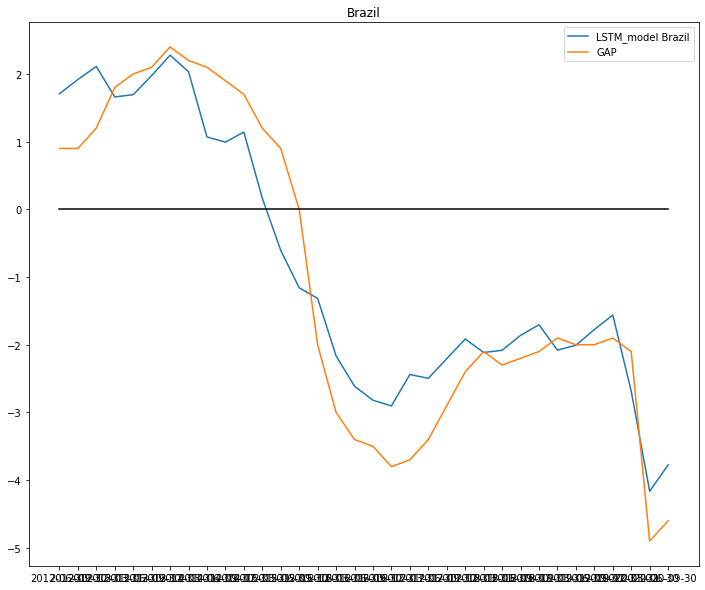

In [ ]:
LSTM_model_BR = model.predict(w) # Brazil
plt.title('Brazil') 
plt.plot(drop_DATE_BR, LSTM_model_BR, label='LSTM_model Brazil')
plt.plot(drop_DATE_BR, z, label='GAP')
plt.plot(drop_DATE_BR, np.zeros(drop_DATE_BR.shape[0]), color='black')
plt.legend()
plt.show()

In [ ]:
BR_data = LSTM_model_BR.flatten() - z
MAE_BR_data = np.sum(np.abs(BR_data))/BR_data.shape
MAE_BR_data

array([0.61408719])

In [ ]:
drop_DATE_BR.shape

(34,)

## Export data

In [ ]:
import datetime
now = datetime.datetime.now().strftime("%Y%m%d_%Hh%M")

In [ ]:
a2 = np.asarray(LSTM_model_BR)
np.savetxt("TL4OG_BR_output_"+now+".csv", a2, delimiter=",")